In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

import kontrol
import kontrol.core.math
import kontrol.core.controlutils

# log10 N_a, log10 N_b, a, b  # copied from IP_noise.ipynb
lvdt_h1_args = [-2.59488005, -1.87371354,  0.61426591,  0.00910531]
lvdt_h2_args = [-2.28542876, -1.81372454,  0.6704747,   0.00981625]
lvdt_h3_args = [-2.53314227, -2.02659373,  0.50476805,  0.00909585]
geo_h1_args = [-4.16425554, -4.59344773,  3.3799076,   0.59570675]
geo_h2_args = [-4.35840285, -4.8259079,   3.12802332,  0.60722819]
geo_h3_args = [-4.38806483, -5.20264628,  3.28124791,  0.40256418]

# From https://gwdoc.icrr.u-tokyo.ac.jp/DocDB/0076/T1807663/003/T1807663-v3%20SR%20Matrix%20Calc.pdf
lvdt2eul = np.array([
    [0.616364, -0.528193, -0.0881709],
    [0.254047, 0.406763, -0.66081],
    [0.556242, 0.556242, 0.556242]])

# From https://klog.icrr.u-tokyo.ac.jp/osl/?r=17180
lvdtalign = np.array([[0.94872, -0.2183, 0.00417], [0.22295, 0.94869, 0.00098], [0.00866, 0.03869, 0.99999]])

lvdt_sensing = lvdtalign @ lvdt2eul

acc2eul = np.array([[0.61811, -0.5187, -0.1179], [0.23597, 0.43458, -0.6507], [0.55946, 0.55951, 0.57380]])
accalign = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

acc_sensing = accalign @ acc2eul
geo_sensing = acc_sensing

In [2]:
f, noise_seis_x = np.loadtxt("../data/X_mean_DISP.txt")[:,0], np.loadtxt("../data/X_mean_DISP.txt")[:,1]
f, noise_seis_y = np.loadtxt("../data/Y_mean_DISP.txt")[:,0], np.loadtxt("../data/Y_mean_DISP.txt")[:,1]

# flatten low frequency content to avoid seismometer noise
i_cutoff = scipy.signal.argrelmin(noise_seis_x)[0][0]
for i in range(len(noise_seis_x)):
    if i < i_cutoff:
        noise_seis_x[i] = noise_seis_x[i_cutoff]
i_cutoff = scipy.signal.argrelmin(noise_seis_y)[0][0]
for i in range(len(noise_seis_y)):
    if i < i_cutoff:
        noise_seis_y[i] = noise_seis_y[i_cutoff]

## ignore high frequency crap
mask = f<30
f = f[mask]
noise_seis_x = noise_seis_x[mask]
noise_seis_y = noise_seis_y[mask]

## Scale to um
noise_seis_x *= 1e6
noise_seis_y *= 1e6

Noise model
\begin{equation}
    N(f) = \left[\left(\frac{N_a}{f^a}\right)^2 + \left(\frac{N_b}{f^b}\right)^2\right]^{\frac{1}{2}}
\end{equation}

In [3]:
def noise_model(f, log_n_a, log_n_b, a, b):
    n_a = 10**log_n_a
    n_b = 10**log_n_b
    return ((n_a/f**a)**2 + (n_b/f**b)**2)**0.5

def cost(args, model, x_data, y_data, weight=None):
    if weight is None:
        weight = np.ones_like(y_data)
    y_model = model(x_data, *args)
    return np.sum(np.abs((np.log(y_model+1e-25) - np.log(y_data+1e-25))*weight))

Text(0.5, 0, 'Frequency (Hz)')

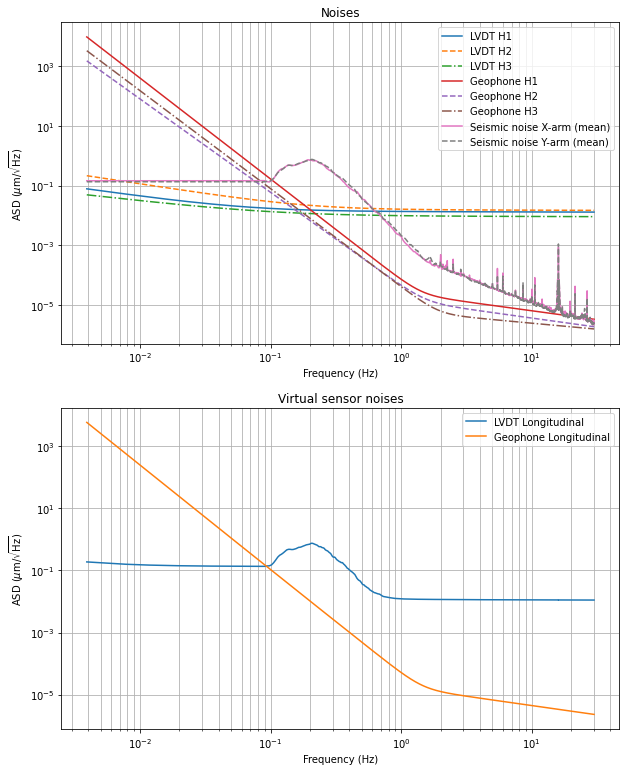

In [4]:
#f = np.linspace(1e-2, 1e1, 1000)
## Raw sensor signals
f_geo = np.linspace(1e-3, 3e1, 10000)

noise_lvdt_h1 = noise_model(f, *lvdt_h1_args)
noise_lvdt_h2 = noise_model(f, *lvdt_h2_args)
noise_lvdt_h3 = noise_model(f, *lvdt_h3_args)
noise_geo_h1 = noise_model(f, *geo_h1_args)
noise_geo_h2 = noise_model(f, *geo_h2_args)
noise_geo_h3 = noise_model(f, *geo_h3_args)

noise_lvdt = np.array([noise_lvdt_h1, noise_lvdt_h2, noise_lvdt_h3])
noise_geo = np.array([noise_geo_h1, noise_geo_h2, noise_geo_h3])

## Virtual sensor signals in longitudinal, transverse, and yaw direction.
noise_lvdt_l = kontrol.core.math.quad_sum(
    lvdt_sensing[0,0]*noise_lvdt[0], lvdt_sensing[0,1]*noise_lvdt[1], lvdt_sensing[0,2]*noise_lvdt[2])
# noise_lvdt_t = kontrol.core.math.quad_sum(
#     lvdt_sensing[1,0]*noise_lvdt[0], lvdt_sensing[1,1]*noise_lvdt[1], lvdt_sensing[1,2]*noise_lvdt[2])
# noise_lvdt_y = kontrol.core.math.quad_sum(
#     lvdt_sensing[2,0]*noise_lvdt[0], lvdt_sensing[2,1]*noise_lvdt[1], lvdt_sensing[2,2]*noise_lvdt[2])
noise_geo_l = kontrol.core.math.quad_sum(
    geo_sensing[0,0]*noise_geo[0], geo_sensing[0,1]*noise_geo[1], geo_sensing[0,2]*noise_geo[2])
# noise_geo_t = kontrol.core.math.quad_sum(
#     geo_sensing[1,0]*noise_geo[0], geo_sensing[1,1]*noise_geo[1], geo_sensing[1,2]*noise_geo[2])
# noise_geo_y = kontrol.core.math.quad_sum(
#     geo_sensing[2,0]*noise_geo[0], geo_sensing[2,1]*noise_geo[1], geo_sensing[2,2]*noise_geo[2])

## Assuming seismic noise coupling in LVDT L and T.
noise_lvdt_l_seis = kontrol.core.math.quad_sum(
    noise_lvdt_l, noise_seis_y)
# noise_lvdt_t_seis = kontrol.core.math.quad_sum(
#     noise_lvdt_t, noise_seis_x)


plt.figure(figsize=(10, 13))
plt.subplot(211, title="Noises")
plt.loglog(f, noise_lvdt_h1, "-", label="LVDT H1")
plt.loglog(f, noise_lvdt_h2, "--", label="LVDT H2")
plt.loglog(f, noise_lvdt_h3, "-.", label="LVDT H3")
plt.loglog(f, noise_geo_h1, "-", label="Geophone H1")
plt.loglog(f, noise_geo_h2, "--",label="Geophone H2")
plt.loglog(f, noise_geo_h3, "-.",label="Geophone H3")
plt.loglog(f, noise_seis_x, "-", label="Seismic noise X-arm (mean)")
plt.loglog(f, noise_seis_y, "--", label="Seismic noise Y-arm (mean)")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")

plt.subplot(212, title="Virtual sensor noises")
# plt.loglog(f, noise_lvdt_l, label="LVDT Longitudinal")
# plt.loglog(f, noise_lvdt_t, label="LVDT Transverse")
plt.loglog(f, noise_lvdt_l_seis, "-", label="LVDT Longitudinal")
# plt.loglog(f, noise_lvdt_t_seis, "--", label="LVDT Transverse")
# plt.loglog(f, noise_lvdt_y, "-.", label="LVDT Yaw")
plt.loglog(f, noise_geo_l, "-", label="Geophone Longitudinal")
# plt.loglog(f, noise_geo_t, "--", label="Geophone Transverse")
# plt.loglog(f, noise_geo_y, "-.", label="Geophone Yaw")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")

# plt.savefig("ip_sensor_noises_empirical.png")

array([1.55082480e+00, 5.47619523e+01, 8.36443781e+02, 7.23241425e+03,
       3.89434444e+04, 1.35690774e+05, 3.09829576e+05, 4.65079549e+05,
       4.61101479e+05, 3.01096951e+05, 1.26767082e+05, 3.25748053e+04,
       4.51142707e+03, 2.41758058e+02, 1.55889986e+02, 2.94825187e+03,
       2.52941318e+04, 1.30343929e+05, 4.49867754e+05, 1.09684724e+06,
       1.93963413e+06, 2.51057507e+06, 2.36600676e+06, 1.58944207e+06,
       7.28313697e+05, 2.08836574e+05, 3.10023033e+04, 1.28153432e+03])

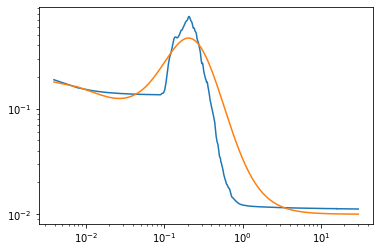

In [5]:
## Fitting Prior (initial guess).

import kontrol.frequency_series.conversion as con

z = [0.02, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.8, 0.8, 0.8, 0.8, 0.8, 1]  # Hand tweaked
p = [0.01, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.3, 0.3, 0.3, 0.5] # Hand tweaked
gain = [noise_lvdt_l_seis[0]]
args = z + p + gain
zpk_model = con.args2zpk(f, args)

plt.loglog(f, noise_lvdt_l_seis)
plt.loglog(f, abs(zpk_model))

zpk_args = args
tf_zpk = con.args2controltf(zpk_args)
tf_args = np.append(tf_zpk.num[0][0], tf_zpk.den[0][0])  # Prior

In [6]:
## Fit LVDT L noise. Fix random seed so results are reproducible.

np.random.seed(123)
n1 = kontrol.FrequencySeries(f, noise_lvdt_l_seis)
_ = n1.fit_zpk(order=1, padding=True, fit="x")  # Order doesn't matter here since we'll be using the prior anyway.
__ = n1.fit_tf(x0=tf_args)

In [7]:
## Fit Geophone L noise. Fix random seed so results are reproducible.

np.random.seed(123)
n2 = kontrol.FrequencySeries(f, noise_geo_l)
_ = n2.fit_zpk(order=4, padding=True, fit="x")
# _ = n2.fit_tf(optimizer_kwargs={"options": {"ftol": 1e-8, "maxfev": int(9*1e6)}})
_ = n2.fit_tf()

In [16]:
## stablize the transfer functions before proceeding 
n1_stable = kontrol.core.controlutils.convert_unstable_tf(n1.tf)
n2_stable = kontrol.core.controlutils.convert_unstable_tf(n2.tf)

In [22]:
plt.rcParams.keys()

KeysView(RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
        

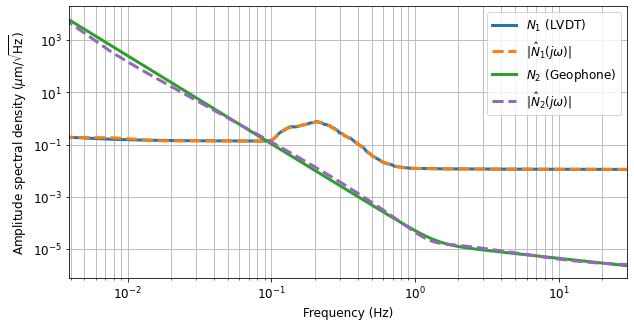

In [27]:
plt.rcParams["font.size"] = 12
plt.rcParams['lines.linewidth'] = 3
plt.figure(figsize=(10, 5))
plt.loglog(n1.f, n1.x, "C0", label="$N_1$ (LVDT)")
# plt.loglog(n1.f_tf, abs(n1.x_tf), "C1--", label=r"$\left\vert\hat{N}_1(j\omega)\right\vert$")
plt.loglog(n1.f_tf, abs(n1_stable(1j*2*np.pi*n1.f_tf)), "C1--", label=r"$\left\vert\hat{N}_1(j\omega)\right\vert$")

plt.loglog(n2.f, n2.x, "C2", label="$N_2$ (Geophone)")
# plt.loglog(n2.f_tf, abs(n2.x_tf), "C4--", label="Geophone noise transfer function fit")
plt.loglog(n2.f_tf, abs(n2_stable(1j*2*np.pi*n2.f_tf)), "C4--", label=r"$\left\vert\hat{N}_2(j\omega)\right\vert$")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude spectral density ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")
plt.xlim(min(f), max(f))
# plt.savefig("ip_l_noise_fit.png")
plt.show()
## We might wanna fit the geophone noise to lower freuqencies like 1e-3 Hz...



In [29]:
## Make complementary filters using H-infinity synthesis

comp = kontrol.ComplementaryFilter(noise1=n1_stable, noise2=n2_stable, f=f, unit="Hz")
comp.hinfsynthesis()


Text(0.5, 0, 'Frequency (Hz)')

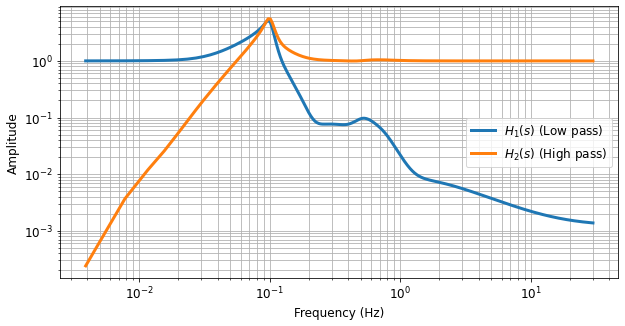

In [30]:
# f_eval = np.logspace(-5, 5, 1000000)
# f_eval=f
plt.figure(figsize=(10, 5))
# plt.subplot(121, title="Complementary Filters")
plt.loglog(comp.f, abs(comp.filter1(2*np.pi*1j*comp.f)), label="$H_1(s)$ (Low pass)")
plt.loglog(comp.f, abs(comp.filter2(2*np.pi*1j*comp.f)), label="$H_2(s)$ (High pass)")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")

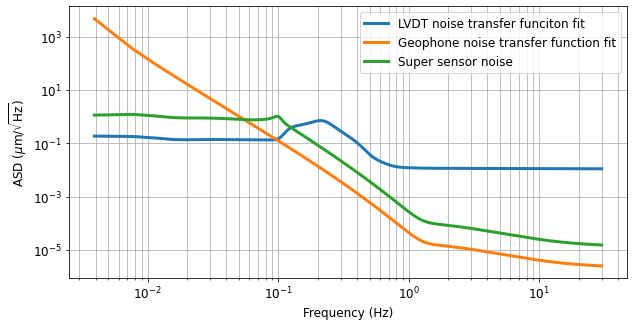

In [31]:
# plt.subplot(122, title="Sensor noises")
plt.figure(figsize=(10, 5))
plt.loglog(comp.f, comp.noise1, label="LVDT noise transfer funciton fit")
plt.loglog(comp.f, comp.noise2, label="Geophone noise transfer function fit")
plt.loglog(comp.f, comp.noise_super, label="Super sensor noise")
# plt.loglog(comp.f, comp_h2.noise_super, "--", label="Super sensor noise (predicted) H2")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")

# plt.savefig("ip_l_complementary_filter_sensor_noises.png")
plt.show()

In [32]:
## Benchmark
import kontrol.complementary_filter.predefined
import control

sekiguchi_filter1, sekiguchi_filter2 = kontrol.complementary_filter.predefined.sekiguchi([0.08*2*np.pi])
noise_super_sekiguchi = kontrol.core.math.quad_sum(
    abs(sekiguchi_filter1(1j*2*np.pi*f))*noise_lvdt_l_seis,
    abs(sekiguchi_filter2(1j*2*np.pi*f))*noise_geo_l
)

s = control.tf("s")
current_filter1 = 1.25 * (s**2 + 0.25*s + 0.025) / (s**5 + 2.5*s**4 + 2.5*s**3 + 1.25*s**2 + 0.3125*s + 0.03125)
current_filter2 = 1-current_filter1
noise_super_current = kontrol.core.math.quad_sum(
    abs(current_filter1(1j*2*np.pi*f))*noise_lvdt_l_seis,
    abs(current_filter2(1j*2*np.pi*f))*noise_geo_l,
)

noise_super_hinfinity = kontrol.core.math.quad_sum(
    abs(comp.filter1(1j*2*np.pi*f))*noise_lvdt_l_seis,
    abs(comp.filter2(1j*2*np.pi*f))*noise_geo_l,
)

df = f[1] - f[0]

expected_rms_current = [np.sqrt(np.sum(noise_super_current[i:]**2*df)) for i in range(len(f))]
# print(expected_rms_current)
expected_rms_sekiguchi = [np.sqrt(np.sum(noise_super_sekiguchi[i:]**2*df)) for i in range(len(f))]
# print(expected_rms_sekiguchi)
expected_rms_hinfinity = [np.sqrt(np.sum(noise_super_hinfinity[i:]**2*df)) for i in range(len(f))]
# print(expected_rms_hinfinity)
# expected_rms_h2 = [np.sqrt(sum(noise_super_h2[i:]**2*df)) for i in range(len(f))]

In [33]:
noise_lower_bound = [min(noise_lvdt_l_seis[i], noise_geo_l[i]) for i in range(len(f))]

In [37]:
expected_rms_current[0]

0.7979151059043099

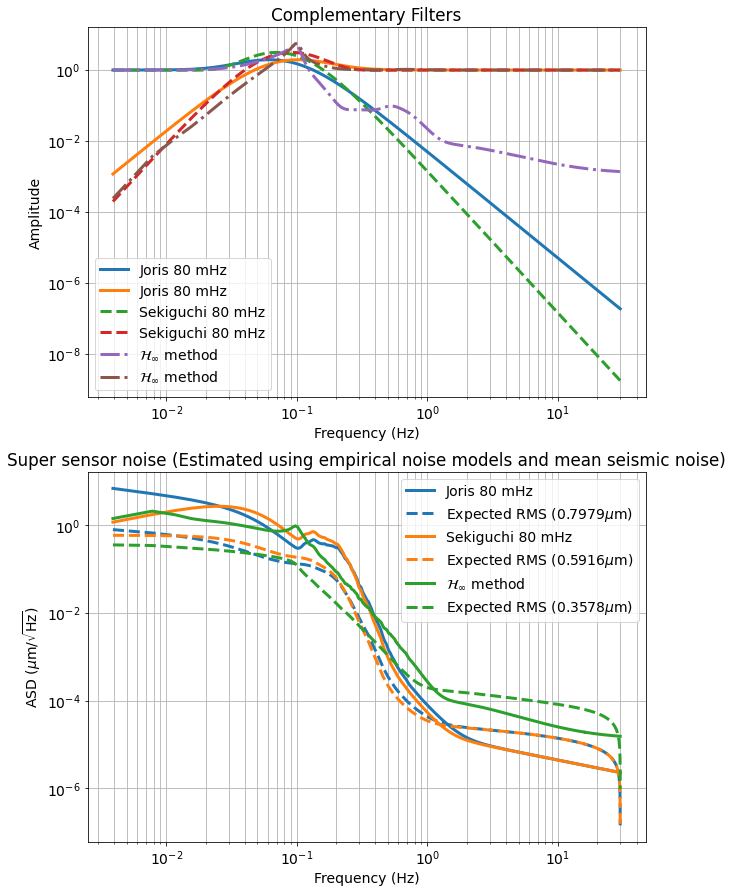

In [43]:
plt.rcParams["font.size"] = 14
plt.figure(figsize=(10, 15))
plt.subplot(211, title="Complementary Filters")
plt.loglog(f, abs(current_filter1(1j*2*np.pi*f)), label="Joris 80 mHz")
plt.loglog(f, abs(current_filter2(1j*2*np.pi*f)), label="Joris 80 mHz")
plt.loglog(f, abs(sekiguchi_filter1(1j*2*np.pi*f)), "--", label="Sekiguchi 80 mHz")
plt.loglog(f, abs(sekiguchi_filter2(1j*2*np.pi*f)), "--", label="Sekiguchi 80 mHz")
plt.loglog(f, abs(comp.filter1(2*np.pi*1j*f)), "-.", label="$\mathcal{H}_\infty$ method")
plt.loglog(f, abs(comp.filter2(2*np.pi*1j*f)), "-.", label="$\mathcal{H}_\infty$ method")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("Amplitude")
plt.xlabel("Frequency (Hz)")

# '#1f77b4', '#ff7f0e', '#2ca02c'
plt.subplot(212, title="Super sensor noise (Estimated using empirical noise models and mean seismic noise)")
plt.loglog(f, noise_super_current, label="Joris 80 mHz")
plt.loglog(f, expected_rms_current, "--", color="#1f77b4", markersize=2,
           label="Expected RMS ({:.4f}".format(expected_rms_current[0]) + r"$\mu \mathrm{m}$)")
plt.loglog(f, noise_super_sekiguchi, label="Sekiguchi 80 mHz")
plt.loglog(f, expected_rms_sekiguchi, "--", color="#ff7f0e", markersize=2,
           label="Expected RMS ({:.4f}".format(expected_rms_sekiguchi[0]) + r"$\mu \mathrm{m}$)")
plt.loglog(f, noise_super_hinfinity, label="$\mathcal{H}_\infty$ method")
plt.loglog(f, expected_rms_hinfinity, "--", color="#2ca02c", markersize=2,
           label="Expected RMS ({:.4f}".format(expected_rms_hinfinity[0]) + r"$\mu \mathrm{m}$)")
# plt.loglog(f, expected_rms_h2, "y.")
# plt.loglog(f, noise_lower_bound, label="Lower bound")
plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
plt.xlabel("Frequency (Hz)")

plt.savefig("ip_complementary_filters_comparison.png")
plt.show()

In [ ]:
# # Yaw
# plt.rcParams["font.size"] = 14
# plt.figure(figsize=(10, 15))
# plt.subplot(211, title="Complementary Filters")
# plt.loglog(f, abs(current_filter1(1j*2*np.pi*f)), label="Joris 159 mHz")
# plt.loglog(f, abs(current_filter2(1j*2*np.pi*f)), label="Joris 159 mHz")
# plt.loglog(f, abs(sekiguchi_filter1(1j*2*np.pi*f)), "--", label="Sekiguchi 159 mHz")
# plt.loglog(f, abs(sekiguchi_filter2(1j*2*np.pi*f)), "--", label="Sekiguchi 159 mHz")
# plt.loglog(f, abs(comp_y.filter1(2*np.pi*1j*f)), "-.", label="$\mathcal{H}_\infty$ method")
# plt.loglog(f, abs(comp_y.filter2(2*np.pi*1j*f)), "-.", label="$\mathcal{H}_\infty$ method")
# plt.legend(loc=0)
# plt.grid(which="both")
# plt.ylabel("Amplitude")
# plt.xlabel("Frequency (Hz)")

# # '#1f77b4', '#ff7f0e', '#2ca02c'
# plt.subplot(212, title="Super sensor noise (Estimated using empirical noise models and mean seismic noise)")
# plt.loglog(f, noise_super_current, label="Joris 159 mHz")
# plt.loglog(f, expected_rms_current, "--", color="#1f77b4", markersize=2, label="Expected RMS (0.1153 $\mu \mathrm{m}$)")
# plt.loglog(f, noise_super_sekiguchi, label="Sekiguchi 159 mHz")
# plt.loglog(f, expected_rms_sekiguchi, "--", color="#ff7f0e", markersize=2, label="Expected RMS (0.5854 $\mu \mathrm{m}$)")
# plt.loglog(f, noise_super_hinfinity, label="$\mathcal{H}_\infty$ method")
# plt.loglog(f, expected_rms_hinfinity, "--", color="#2ca02c", markersize=2, label="Expected RMS (0.1213 $\mu \mathrm{m}$)")
# # plt.loglog(f, expected_rms_h2, "y.")
# # plt.loglog(f, noise_lower_bound, label="Lower bound")
# plt.legend(loc=0)
# plt.grid(which="both")
# plt.ylabel("ASD ($\mu\mathrm{m}/\sqrt{\mathrm{Hz}}$)")
# plt.xlabel("Frequency (Hz)")

# # plt.savefig("ip_complementary_filters_comparison.png")
# plt.show()